# Capstone Project  – Neighbourhoods of Denmark


This project was completed as part of the IBM Data Science Professional Certificate and makes up the Applied Data Science Capstone Project “The Battle of Neighbourhoods”.

## Part 1 - Data preparation / Scraping and Cleaning Data

### Section 1 - Scraping and Cleaning Data

Import all the libaries needed for the data preparation

In [1]:
import pandas as pd
from pprint import pprint # for pretty print of e.g. json
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests

#### Postal codes and names for all the Danish neighbourhoods

Data about the Danish postal codes are available from www.edemann.dk

In [2]:
# Import Danish postal codes from url using Pandas
df = pd.read_html('https://edemann.dk/liste-danske-postnumre-og-byer/')
df = df[0]  # Only the first table in the dataframe is of interest

The dataframe columns are missing names. First column is the postal codes and the second the neighbourhood name

In [3]:
# Add column names
df.columns = ['PostalCode', 'Neighbourhood']
df.head(5)

,PostalCode,Neighbourhood
0,1301,København K
1,2000,Frederiksberg
2,2100,København Ø
3,2200,København N
4,2300,København S


Check if the dataframe contains any nulls or inconsistencies in data type etc.

In [4]:
# Get info of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 580 entries, 0 to 579
Data columns (total 2 columns):
PostalCode       580 non-null int64
Neighbourhood    580 non-null object
dtypes: int64(1), object(1)
memory usage: 9.2+ KB


The data seem okay. No incidences of nulls and consistent data types.

#### Coordinate data for the Danish neighbourhoods

Use the Python libary geopy to get the location (latitudeand longitude) for each of the Danish neighbourhoods.

In [5]:
from geopy.extra.rate_limiter import RateLimiter

# Define function that from a list of neighbourhood names return a dataframe with geo coordinates
def getGeoLocation(neighbourhoods_names):
    
    # initiate geolocator
    geolocator = Nominatim(user_agent="city_explorer")
    
    # incorporate a rate limiter
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
    
    # initiate dataframe with columns
    df = pd.DataFrame(columns=['Neighbourhood', 'Latitude', 'Longitude'])
    
    # loop over neighbourhoods
    for name in neighbourhoods_names:
        print('Looking up:', name, end='')
        address = name + ', Danmark'  # add country code
        location = geocode(address)  # look up address
        try:
            lat, lng = location.latitude, location.longitude  # extract coordinates
            print(f'... location: ({lat}, {lng})')
        except Exception as e:
            print(e)
            #print(e.headers)
            print('... failed')
            continue
        # append information to dataframe
        df = df.append({'Neighbourhood':name, 'Latitude':lat, 'Longitude':lng}, ignore_index=True)

    return(df)

Get location of all the neighbourhoods

In [6]:
# get geo locations
# locations = getGeoLocation(df.iloc[:]['Neighbourhood'])

In [7]:
# store the data using pickle for easy retrieval
# locations.to_pickle('locations.pkl')
locations = pd.read_pickle('locations.pkl')

In [8]:
locations.head()

,Neighbourhood,Latitude,Longitude
0,København K,55.686724,12.570072
1,Frederiksberg,55.678016,12.532619
2,København Ø,55.686724,12.570072
3,København N,55.686724,12.570072
4,København S,55.686724,12.570072


### Section 2 - Combine data (add geospatial coordinates)

Now the original dataframe *df* is enriched by this this coordinates data

In [9]:
# add the coordinates to the *df* dataframe by merging the two tables
neighbourhoods = pd.merge(df, locations, on='Neighbourhood')

In [10]:
neighbourhoods.head(10)

,PostalCode,Neighbourhood,Latitude,Longitude
0,1301,København K,55.686724,12.570072
1,2000,Frederiksberg,55.678016,12.532619
2,2100,København Ø,55.686724,12.570072
3,2200,København N,55.686724,12.570072
4,2300,København S,55.686724,12.570072
5,2400,København NV,55.683481,12.572832
6,2450,København SV,55.676614,12.569492
7,2500,Valby,55.661802,12.516952
8,2600,Glostrup,55.669248,12.395952
9,2605,Brøndby,55.644111,12.421713


Merge neighbourhoods where geo location is the same

In [11]:
df_grouped = neighbourhoods.groupby('Longitude').agg(list).sort_values('PostalCode')
df_grouped.head()

,PostalCode,Neighbourhood,Latitude
Longitude,,,
12.570072,"[1301, 2100, 2200, 2300]","[København K, København Ø, København N, Københ...","[55.6867243, 55.6867243, 55.6867243, 55.6867243]"
12.532619,[2000],[Frederiksberg],[55.678016]
12.572832,[2400],[København NV],[55.683481]
12.569492,[2450],[København SV],[55.6766138]
12.516952,[2500],[Valby],[55.6618019]


In [12]:
# replace list of latitudes with the first element of the list as they are identical
df_grouped['Latitude'] = df_grouped['Latitude'].apply(lambda x: x[0])
# replace list of neighbourhood names with joined string
df_grouped['Neighbourhood'] = df_grouped['Neighbourhood'].apply(lambda x: ', '.join(x))
# replace list of postal codes with joined string
df_grouped['PostalCode'] = df_grouped['PostalCode'].apply(lambda x: ', '.join( str(elm) for elm in x ))
# reset index
df_grouped = df_grouped.reset_index()
df_grouped.head()

,Longitude,PostalCode,Neighbourhood,Latitude
0,12.570072,"1301, 2100, 2200, 2300","København K, København Ø, København N, Københa...",55.686724
1,12.532619,2000,Frederiksberg,55.678016
2,12.572832,2400,København NV,55.683481
3,12.569492,2450,København SV,55.676614
4,12.516952,2500,Valby,55.661802


In [13]:
# extract the dataframe columns and rearrange them
cols = df_grouped.columns.tolist()
cols = cols[1:] + cols[:1]

In [14]:
df_grouped = df_grouped[cols]
df_grouped.head()

,PostalCode,Neighbourhood,Latitude,Longitude
0,"1301, 2100, 2200, 2300","København K, København Ø, København N, Københa...",55.686724,12.570072
1,2000,Frederiksberg,55.678016,12.532619
2,2400,København NV,55.683481,12.572832
3,2450,København SV,55.676614,12.569492
4,2500,Valby,55.661802,12.516952


In [15]:
# overwrite the original *neighbourhoods* dataframe
neighbourhoods = df_grouped

#### Get venues from Foursquare

Define Foursquare Credentials and Version

In [16]:
CLIENT_ID = 'QUYUMKRM1VQVFX1G0I5G5SJFJB4PHR3T1VQMHUW1COOD5UEJ' # your Foursquare ID
CLIENT_SECRET = 'KCN02PP1RIXEKIGXSHITULMECMZJ1Q3LDJVBICDX1L1GKPR5' # your Foursquare Secret
VERSION = '20190908' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QUYUMKRM1VQVFX1G0I5G5SJFJB4PHR3T1VQMHUW1COOD5UEJ
CLIENT_SECRET:KCN02PP1RIXEKIGXSHITULMECMZJ1Q3LDJVBICDX1L1GKPR5


Get the top 100 venues that are within a radius of 2500 meters

In [17]:
# input parameters
limit = 100 # limit of number of venues returned by Foursquare API
radius = 2500 # define radius

defines the function that extracts the 100 venues for each neighbourhoods

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = f'https://api.foursquare.com/v2/venues/explore?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={lat},{lng}&radius={radius}&limit={limit}'

        try:
            # make the GET request
            data = requests.get(url).json()
            #pprint(data["response"]['groups'][0])
            results = data["response"]['groups'][0]['items']

            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'],
                v['venue']['categories'][0]['name'],
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'] ) for v in results])
        except Exception as e:
            print(e)

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Category', 
                  'Venue Latitude', 
                  'Venue Longitude']
    
    return(nearby_venues)

excecute the above function on each Neighbourhood and create a new dataframe.

Let's look up a specific city 'Kongens Lyngby'

In [19]:
Lyngby = neighbourhoods.loc[neighbourhoods['Neighbourhood']=='Kongens Lyngby']
Lyngby

,PostalCode,Neighbourhood,Latitude,Longitude
28,2800,Kongens Lyngby,55.771865,12.505141


Get nearby venues

In [20]:
lyngby_venues = getNearbyVenues(names=Lyngby['Neighbourhood'],
                                   latitudes=Lyngby['Latitude'],
                                   longitudes=Lyngby['Longitude'],
                                   radius=radius,
                                   limit=limit)

Kongens Lyngby


Evaluate the dataframe content

In [21]:
print(lyngby_venues.shape)
lyngby_venues.head(10)

(80, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Category,Venue Latitude,Venue Longitude
0,Kongens Lyngby,55.771865,12.505141,Sticks'n'Sushi,Sushi Restaurant,55.770193,12.505784
1,Kongens Lyngby,55.771865,12.505141,Det Sunde Køkken,Fast Food Restaurant,55.769333,12.505093
2,Kongens Lyngby,55.771865,12.505141,Wokshop,Thai Restaurant,55.769113,12.505265
3,Kongens Lyngby,55.771865,12.505141,Big Mamas Pizza House,Pizza Place,55.770937,12.499931
4,Kongens Lyngby,55.771865,12.505141,Magasin Lyngby,Department Store,55.770190,12.505017
5,Kongens Lyngby,55.771865,12.505141,Meyers Spisehus,Diner,55.769801,12.505433
6,Kongens Lyngby,55.771865,12.505141,Gordion Café og Restaurant,Pizza Place,55.767780,12.501952
7,Kongens Lyngby,55.771865,12.505141,Kinopalæet,Movie Theater,55.771272,12.507214
8,Kongens Lyngby,55.771865,12.505141,Lyngby Storcenter,Shopping Mall,55.771932,12.505966
9,Kongens Lyngby,55.771865,12.505141,Lyngby Shawarma,Middle Eastern Restaurant,55.771102,12.506972


Now for all the neighbourhoods

In [22]:
#venues = getNearbyVenues(names=neighbourhoods['Neighbourhood'],
#                         latitudes=neighbourhoods['Latitude'],
#                         longitudes=neighbourhoods['Longitude'],
#                         radius=radius,
#                         limit=limit)

In [23]:
# store the data using pickle for easy retrieval
# venues.to_pickle('venues.pkl')
venues = pd.read_pickle('venues.pkl')

Evaluate the dataframe content

In [24]:
print(venues.shape)
venues.head(10)

(6331, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Category,Venue Latitude,Venue Longitude
0,"København K, København Ø, København N, Københa...",55.686724,12.570072,Botanisk Have,Botanical Garden,55.686169,12.573246
1,"København K, København Ø, København N, Københa...",55.686724,12.570072,Palmehuset,Garden,55.687578,12.572960
2,"København K, København Ø, København N, Københa...",55.686724,12.570072,Torvehallerne,Food Court,55.683934,12.569244
3,"København K, København Ø, København N, Københa...",55.686724,12.570072,The Coffee Collective,Coffee Shop,55.683695,12.569790
4,"København K, København Ø, København N, Københa...",55.686724,12.570072,Naturbageriet,Bakery,55.685121,12.568073
5,"København K, København Ø, København N, Københa...",55.686724,12.570072,Tapa del Toro,Tapas Restaurant,55.683962,12.569356
6,"København K, København Ø, København N, Københa...",55.686724,12.570072,Mikropolis,Beer Bar,55.685049,12.565860
7,"København K, København Ø, København N, Københa...",55.686724,12.570072,Hallernes Smørrebrød,Sandwich Place,55.683870,12.569125
8,"København K, København Ø, København N, Københa...",55.686724,12.570072,Kalaset,Café,55.684608,12.566576
9,"København K, København Ø, København N, Københa...",55.686724,12.570072,Höst,Scandinavian Restaurant,55.683279,12.566076


Let's check how many venues were returned for each Neighbourhood

In [25]:
# Number of venues found per neighbourhood sorted ascending
sorted_count = venues[['Neighbourhood', 'Venue']].groupby('Neighbourhood').count().sort_values(by='Venue', ascending=True)
sorted_count.reset_index().head()

,Neighbourhood,Venue
0,Flemming,1
1,Boeslunde,1
2,Hørning,1
3,Stenderup,1
4,Vestervig,1


For simplicity only neighbourhoods with more than 10 nearby venues are considered from now on.

In [26]:
# indexes to be kept / which have more than 10 venues
neighbourhood_indexes_to_keep = sorted_count[sorted_count['Venue'] > 10].index
neighbourhood_indexes_to_keep.shape

(129,)

In [27]:
# reduce the number of condidered venues
venues = venues.set_index('Neighbourhood').loc[neighbourhood_indexes_to_keep].reset_index()
venues.shape

(4415, 7)

In [28]:
# reduce the number of condidered neighbourhoods
neighbourhoods = neighbourhoods.set_index('Neighbourhood').loc[neighbourhood_indexes_to_keep].sort_values(by='PostalCode').reset_index()
neighbourhoods.shape

(129, 4)

In [29]:
# redo the sorted count
sorted_count_reduced = venues[['Neighbourhood', 'Venue']].groupby('Neighbourhood').count().sort_values(by='Venue', ascending=True)

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
#sns.set(style="whitegrid")

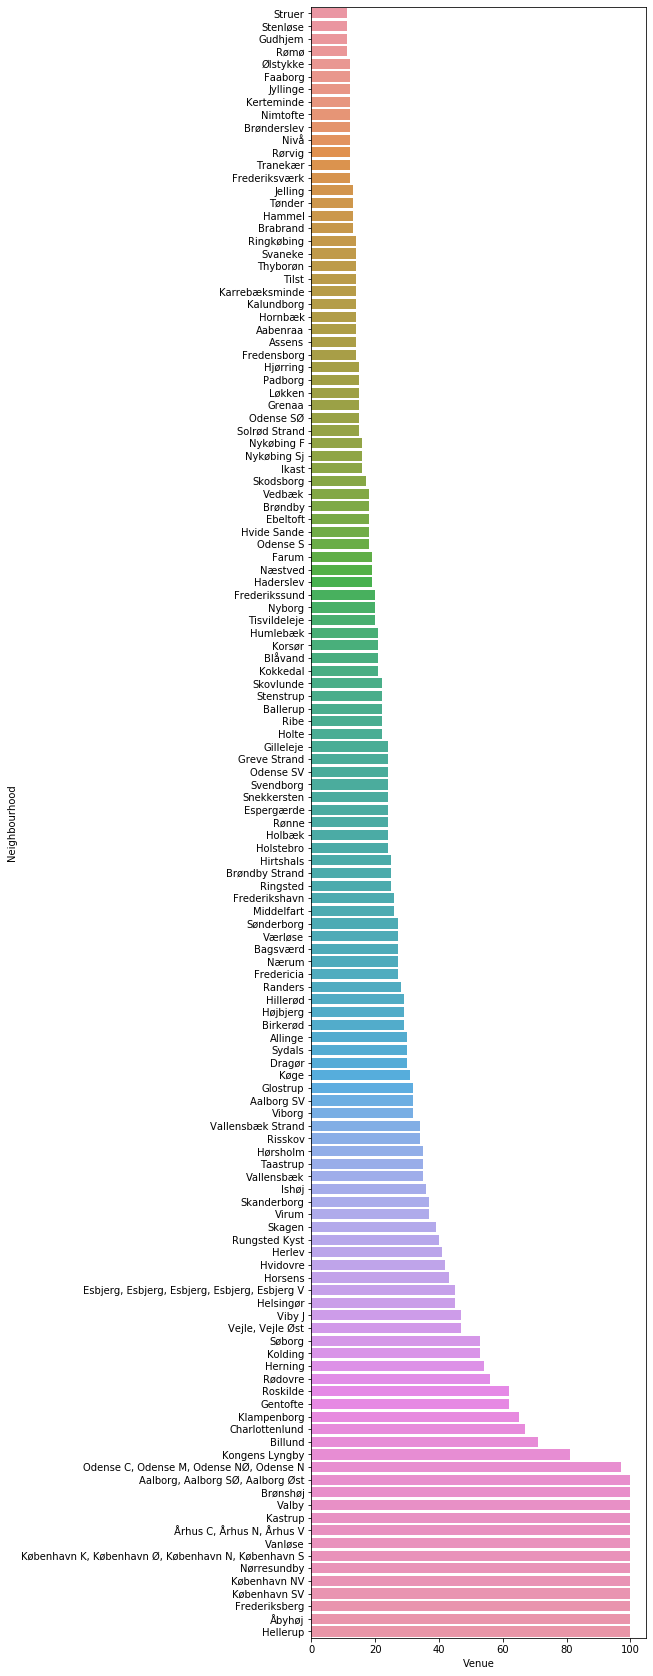

In [31]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 30))

# Plot
sns.barplot(x="Venue", y="Neighbourhood", data=sorted_count_reduced.reset_index())

## Part 2 - Data Analysis and Visualisation

Import all the python libaries needed

In [32]:
import numpy as np
import folium # map rendering library

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Section 1 - Visualise data on a map

#### Map of all the Danish neighbourhoods

In [33]:
# Define function for finding the midrange (useful for centering of maps)
def MidRange(values):
    return (values.max() + values.min()) / 2

In [34]:
# create map
mid_latitude = MidRange(neighbourhoods['Latitude'].values)
mid_longitude = MidRange(neighbourhoods['Longitude'].values)
map_DK = folium.Map(location=[mid_latitude, mid_longitude], zoom_start=7)

# add markers to map
for i, neighbourhood in neighbourhoods.iterrows():    
    lat = neighbourhood['Latitude']
    lng = neighbourhood['Longitude']
    name = neighbourhood['Neighbourhood']
    pc = neighbourhood['PostalCode']
    #lat, lng, venue in zip(holte_venues['Venue Latitude'], holte_venues['Venue Longitude'], holte_venues['Venue']):
    label = f'{name} ({pc})'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='#99a8ff', # light blue
        fill=False,
        #fill_color='lightblue',
        fill_opacity=0.5,
        parse_html=False).add_to(map_DK)  
    
for i, location in locations.iterrows():    
    lat = location['Latitude']
    lng = location['Longitude']
    name = location['Neighbourhood']
    #lat, lng, venue in zip(holte_venues['Venue Latitude'], holte_venues['Venue Longitude'], holte_venues['Venue']):
    label = f'{name}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=1.0,
        parse_html=False).add_to(map_DK)  
    
map_DK

The green dots represent all the initial neighbourheeds and the blue circles those left after filtering on minimum number of venues.

#### Map of Lyngby with venues superimposed on top

In [35]:
# create map using latitude and longitude values
map_lyngby = folium.Map(location=[Lyngby['Latitude'], Lyngby['Longitude']], zoom_start=14)

# add markers to map
for i, venue in lyngby_venues.iterrows():    
    lat = venue['Venue Latitude']
    lng = venue['Venue Longitude']
    name = venue['Venue']
    cat = venue['Venue Category']
    label = '{}, {}'.format(name, cat)
    label = folium.Popup(label, parse_html=True)
    
    folium.Circle(
        location=[Lyngby['Latitude'], Lyngby['Longitude']],
        radius=2500,
        line_color='#3186cc',
      #  fill=True,
      #  fill_opacity=0.5,
      #  fill_color='#3186cc'
    ).add_to(map_lyngby)

    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lyngby)  
    
map_lyngby

### Section 2 - Clustering of neighbourhoods

Exploration and clustering of the neighbourhoods in ....

#### Find out how many unique categories can be curated from all the returned venues

In [36]:
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))

There are 279 uniques categories.


#### Analyze the Neighbourhoods

In [37]:
# one hot encoding
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add Neighbourhood column back to dataframe
onehot['Neighbourhood'] = venues['Neighbourhood'] 

# move Neighbourhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

onehot.head(10)

,Neighbourhood,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Bathing Area,Bay,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Camera Store,Campground,Canal,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Castle,Cemetery,Chinese Restaurant,Chocolate Shop,Church,Circus,City,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dog Run,Dumpling Restaurant,Duty-free Shop,Electronics Store,Elementary School,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Forest,French Restaurant,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Rink,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Leather Goods Store,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Neighborhood,Nightclub,Office,Optical Shop,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Outlet Store,Paintball Field,Palace,Park,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Pool,Port,Pub,Public Art,Racecourse,Racetrack,Rafting,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Resort,Rest Area,Restaurant,River,Road,Rock Club,Roof Deck,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Ski Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Squash Court,Stadium,Steakhouse,Street Food Gathering,Summer Camp,Supermarket,Surf Spot,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Tourist Information Center,Toy / Game Store,Track,Track Stadium,Trail,Train,Train Station,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Water Park,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,Gudhjem,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

And let's examine the new dataframe size.

In [38]:
onehot.shape

(4415, 280)

#### Next, let's group rows by Neighbourhood and by taking the mean of the frequency of occurrence of each category

In [39]:
grouped = onehot.groupby('Neighbourhood').mean().reset_index()
grouped.head(20)

,Neighbourhood,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Bathing Area,Bay,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Camera Store,Campground,Canal,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Castle,Cemetery,Chinese Restaurant,Chocolate Shop,Church,Circus,City,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dog Run,Dumpling Restaurant,Duty-free Shop,Electronics Store,Elementary School,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Forest,French Restaurant,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Rink,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Leather Goods Store,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Neighborhood,Nightclub,Office,Optical Shop,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Outlet Store,Paintball Field,Palace,Park,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Pool,Port,Pub,Public Art,Racecourse,Racetrack,Rafting,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Resort,Rest Area,Restaurant,River,Road,Rock Club,Roof Deck,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Ski Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Squash Court,Stadium,Steakhouse,Street Food Gathering,Summer Camp,Supermarket,Surf Spot,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Tourist Information Center,Toy / Game Store,Track,Track Stadium,Trail,Train,Train Station,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Water Park,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,Aabenraa,0.0,0.00,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.071429,0.000000,0.000000,0.0,0.000000,0.000000,0.071429,0.000000,0.00,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.

#### Let's confirm the new size

In [40]:
grouped.shape

(129, 280)

#### Let's print each Neighbourhood along with the top 5 most common venues

In [41]:
num_top_venues = 5

for hood in grouped['Neighbourhood']:
    print("----" + hood + "----")
    temp = grouped[grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Aabenraa----
                  venue  freq
0                  Café  0.14
1       Harbor / Marina  0.14
2                   Pub  0.07
3  Gym / Fitness Center  0.07
4                Bakery  0.07


----Aalborg SV----
           venue  freq
0  Grocery Store  0.16
1         Bakery  0.06
2    Coffee Shop  0.06
3    Supermarket  0.06
4            Zoo  0.03


----Aalborg, Aalborg SØ, Aalborg Øst----
                  venue  freq
0                  Café  0.14
1    Italian Restaurant  0.05
2  Gym / Fitness Center  0.05
3                  Park  0.04
4            Restaurant  0.04


----Allinge----
        venue  freq
0       Hotel  0.17
1        Café  0.13
2  Restaurant  0.07
3   Mini Golf  0.03
4         Bay  0.03


----Assens----
                    venue  freq
0           Grocery Store  0.14
1         Harbor / Marina  0.14
2          Discount Store  0.14
3  Furniture / Home Store  0.07
4             Gas Station  0.07


----Bagsværd----
             venue  freq
0    Grocery Store  0.22
1    

                venue  freq
0       Grocery Store  0.14
1  Italian Restaurant  0.09
2   Convenience Store  0.09
3         Pizza Place  0.09
4         Supermarket  0.09


----Hornbæk----
            venue  freq
0  Ice Cream Shop  0.14
1            Café  0.14
2  Discount Store  0.07
3           Hotel  0.07
4   Grocery Store  0.07


----Horsens----
            venue  freq
0   Grocery Store  0.07
1             Bar  0.05
2  Discount Store  0.05
3            Café  0.05
4     Music Venue  0.05


----Humlebæk----
                     venue  freq
0  Scandinavian Restaurant  0.14
1                     Café  0.10
2            Grocery Store  0.10
3        French Restaurant  0.05
4                     Farm  0.05


----Hvide Sande----
                venue  freq
0              Bakery  0.17
1  Seafood Restaurant  0.11
2                Café  0.11
3         Fish Market  0.11
4       Grocery Store  0.11


----Hvidovre----
                  venue  freq
0         Grocery Store  0.12
1  Gym / Fitness Cente

                  venue  freq
0         Grocery Store  0.14
1  Gym / Fitness Center  0.11
2           Supermarket  0.07
3           Pizza Place  0.05
4         Shopping Mall  0.05


----Rømø----
            venue  freq
0  Ice Cream Shop  0.18
1   Grocery Store  0.09
2            Café  0.09
3   Shopping Mall  0.09
4      Restaurant  0.09


----Rønne----
             venue  freq
0    Boat or Ferry  0.25
1  Harbor / Marina  0.08
2            Hotel  0.08
3             Café  0.08
4    Grocery Store  0.08


----Rørvig----
                venue  freq
0  Seafood Restaurant  0.17
1               Beach  0.17
2       Grocery Store  0.17
3     Harbor / Marina  0.08
4      Ice Cream Shop  0.08


----Skagen----
                venue  freq
0               Hotel  0.13
1       Grocery Store  0.08
2  Seafood Restaurant  0.08
3          Lighthouse  0.05
4               Plaza  0.05


----Skanderborg----
                  venue  freq
0           Music Venue  0.16
1                   Bar  0.05
2  Gym / Fitn

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [42]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each Neighbourhood.

In [43]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['Neighbourhood'] = grouped['Neighbourhood']

for ind in np.arange(grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aabenraa,Harbor / Marina,Café,Convenience Store,Soccer Field,Bakery,Discount Store,Beach,Gym / Fitness Center,Pub,Supermarket
1,Aalborg SV,Grocery Store,Coffee Shop,Bakery,Supermarket,Chinese Restaurant,Bookstore,Sporting Goods Shop,Burger Joint,Shopping Mall,Scandinavian Restaurant
2,"Aalborg, Aalborg SØ, Aalborg Øst",Café,Italian Restaurant,Gym / Fitness Center,Pub,Restaurant,Scandinavian Restaurant,Park,Sandwich Place,Music Venue,Movie Theater
3,Allinge,Hotel,Café,Restaurant,Fast Food Restaurant,Supermarket,Bed & Breakfast,Beach,Bay,Campground,Bar
4,Assens,Grocery Store,Discount Store,Harbor / Marina,Rental Car Location,Coffee Shop,Boat or Ferry,Stadium,Furniture / Home Store,Gas Station,Supermarket


### Cluster Neighbourhoods

The K-Means algorithm is used to cluster the neighbourhoods. This method requires the number of clusters given as an input. For determining the optimal number of clusters the Elbow Method is applied.

In [44]:
# remove neighbourhood name from training data
grouped_clustering = grouped.drop('Neighbourhood', 1)
grouped_clustering.head()

,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Bathing Area,Bay,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Camera Store,Campground,Canal,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Castle,Cemetery,Chinese Restaurant,Chocolate Shop,Church,Circus,City,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dog Run,Dumpling Restaurant,Duty-free Shop,Electronics Store,Elementary School,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Forest,French Restaurant,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Rink,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Leather Goods Store,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Neighborhood,Nightclub,Office,Optical Shop,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Outlet Store,Paintball Field,Palace,Park,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Pool,Port,Pub,Public Art,Racecourse,Racetrack,Rafting,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Resort,Rest Area,Restaurant,River,Road,Rock Club,Roof Deck,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Ski Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Squash Court,Stadium,Steakhouse,Street Food Gathering,Summer Camp,Supermarket,Surf Spot,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Tourist Information Center,Toy / Game Store,Track,Track Stadium,Trail,Train,Train Station,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Water Park,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.071429,0.000000,0.0,0.0,0.0,0.000000,0.071429,0.000000,0.00,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.142857,0.0,0.0

#### Elbow Method
The ideal clustering is here taken as the clusters that yields the minimum *total intra-cluster variation* or *total within-cluster sum of square* (WSS). A measure describing how compact the clustering is and is available via the inertia_ attribute.

In [45]:
# Determine WSS for a series of different number of clusters
wss = []
K = range(1,12)
for k in K:
    kmeans = KMeans(init="k-means++", n_clusters=k, n_init=100)
    kmeans.fit(grouped_clustering)
    wss.append(kmeans.inertia_)

Now the WSS is plottet against K, the number of clusters. The Elbow method says that the optimal K is at the bend.

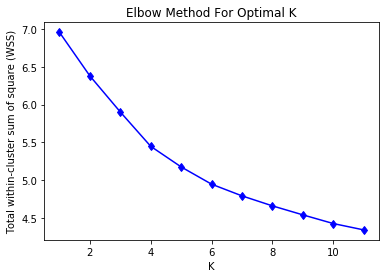

In [46]:
plt.plot(K, wss, 'bd-')
plt.title('Elbow Method For Optimal K')
plt.xlabel('K')
plt.ylabel('Total within-cluster sum of square (WSS)')
plt.show()

The optimal is approximately K = 5.

Run K-Means to cluster the Neighbourhood into the ideal 5 clusters.

In [47]:
# set number of clusters
K = 5

# Initialize KMeans with these predefined input parameters
kmeans = KMeans(init="k-means++", n_clusters=K, n_init=500)

# Now fit the KMeans model with the feature matrix.
kmeans.fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 0, 2, 2, 4, 4, 0, 2, 4, 2, 0, 0, 0, 4, 0, 2, 2, 2, 2, 2, 1, 4,
       0, 0, 2, 1, 0, 0, 0, 2, 0, 1, 4, 2, 0, 0, 2, 2, 0, 2, 4, 1, 0, 4,
       4, 0, 2, 2, 2, 2, 0, 0, 4, 4, 2, 4, 4, 1, 2, 2, 2, 2, 4, 2, 0, 4,
       2, 2, 2, 2, 2, 0, 3, 2, 0, 0, 4, 0, 4, 2, 2, 0, 0, 4, 0, 0, 2, 2,
       4, 0, 2, 0, 0, 2, 1, 2, 2, 0, 2, 0, 0, 4, 4, 2, 0, 2, 2, 2, 4, 2,
       2, 1, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 4])

Let's create a new dataframe that includes the neighbourhood details as well as the top 10 venues for each neighbourhood.

In [48]:
# merge with neighbourhood data to add latitude/longitude coordinates
merged = neighbourhoods.join(venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

Now add the corresponding cluster label to this dataframe

In [49]:
# drop Cluster Labels if the column already exist
try: 
    merged.drop(columns='Cluster Labels', inplace=True)
except Exception as e:
    print('Exception:', e)

Exception: "['Cluster Labels'] not found in axis"


In [50]:
# add clustering labels
merged.insert(0, 'Cluster Labels', kmeans.labels_)

In [51]:
# check for nulls
merged[merged['Cluster Labels'].isnull()].size

0

Now the resulting clusters are visualised. The cluster containing Kongens Lyngby is heighligted.

In [52]:
# Identity cluster containing Kongens Lyngby
lyngby_label = merged.set_index('Neighbourhood').loc['Kongens Lyngby']['Cluster Labels']
lyngby_label

0

In [53]:
# create map
map_clusters = folium.Map(location=[mid_latitude, mid_longitude], zoom_start=7)

# set color scheme for the clusters
x = np.arange(K)
ys = [i + x + (i*x)**2 for i in range(K)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Latitude'], merged['Longitude'], merged['Neighbourhood'], merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    if cluster == lyngby_label:
        radius = 4
        opacity = 0.9
        color = 'black'
    else:
        radius = 3
        opacity = 0.3
        color = rainbow[cluster-1]
    folium.CircleMarker(
        [lat, lon],
        radius=radius,
        popup=label,
        color=color,
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=opacity).add_to(map_clusters)
       
map_clusters

The clusters appear to have a very distinct geographical pattern. However, why too many neighbourhoods are identified similar to Kongens Lyngby.

#### More, but smaller clusters
To reduce the number of similar neighbourhood obtained, the analysis is now repeated with a much higher number of clusters

In [54]:
# set number of clusters
K = 90

# Initialize KMeans with these predefined input parameters
kmeans = KMeans(init="k-means++", n_clusters=K, n_init=100)

# Now fit the KMeans model with the feature matrix.
kmeans.fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([54, 30, 66,  5, 52, 71, 30, 25, 36, 76, 18, 78, 19, 39,  4, 14, 14,
       53, 10,  7,  8, 71, 58, 30, 17, 65, 75, 48,  2, 81, 30, 11, 63, 51,
       89, 37,  4,  0,  4,  1, 73, 12, 68, 77, 55, 41, 31,  1, 79, 33,  4,
       69,  9, 44, 19, 29, 60, 40, 13, 30, 34, 14, 87,  1, 30, 16, 17, 17,
       17, 10, 46, 62,  3, 21, 22, 70, 43, 88, 23, 66,  1, 45, 45, 61, 47,
       84,  0, 50, 73, 67, 10,  9,  4, 20, 64, 38, 82, 86, 26, 80, 74, 72,
        6, 31, 15, 42, 59, 28,  9, 28, 85, 32, 24, 57, 27, 49, 17, 19, 19,
        4, 56, 66, 83, 69, 41, 41, 66, 17, 35])

The *merged* dataframe is now updated with the new cluster labels

In [55]:
# drop Cluster Labels if the column already exist
try: 
    merged.drop(columns='Cluster Labels', inplace=True)
except Exception as e:
    print('Exception:', e)

In [56]:
# add clustering labels
merged.insert(0, 'Cluster Labels', kmeans.labels_)

In [57]:
# check for nulls
merged[merged['Cluster Labels'].isnull()].size

0

Again, the resulting clusters are visualised.

In [58]:
# Identity cluster containing Kongens Lyngby
lyngby_label = merged.set_index('Neighbourhood').loc['Kongens Lyngby']['Cluster Labels']

In [59]:
# create map
map_clusters = folium.Map(location=[mid_latitude, mid_longitude], zoom_start=7)

# set color scheme for the clusters
x = np.arange(K)
ys = [i + x + (i*x)**2 for i in range(K)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Latitude'], merged['Longitude'], merged['Neighbourhood'], merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    if cluster == lyngby_label:
        radius = 5
        opacity = 0.9
        color = 'black'
    else:
        radius = 3
        opacity = 0.3
        color = rainbow[cluster-1]
    folium.CircleMarker(
        [lat, lon],
        radius=radius,
        popup=label,
        color=color,
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=opacity).add_to(map_clusters)
       
map_clusters

#### Examine Kongens Lyngby's Cluster

Finally, each of the clusters are examined and the different categories are attempted described.

In [60]:
# get dataframe with neighbourhoods similar to Kongens Lyngby
df_similar = merged.loc[merged['Cluster Labels'] == lyngby_label].set_index('Neighbourhood')

In [61]:
# drop unnessesary columns
df_similar = df_similar[df_similar.columns[list(range(4, df_similar.shape[1]))]]
#df_similar = df_similar.drop(columns='Cluster Labels').set_index('Neighbourhood')

In [62]:
# Remove Kongens Lyngby from the list
# df_similar = df_similar.set_index('Neighbourhood').drop('Kongens Lyngby')
print('shape:', df_similar.shape)
df_similar

shape: (6, 10)


,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighbourhood,,,,,,,,,,
Frederiksberg,Café,Park,Cocktail Bar,Beer Bar,Bakery,Coffee Shop,Wine Bar,Pizza Place,Music Venue,Scandinavian Restaurant
Brøndby,Furniture / Home Store,Fast Food Restaurant,Gym / Fitness Center,Lounge,Gas Station,Discount Store,Bakery,Museum,Shop & Service,Supermarket
Kongens Lyngby,Grocery Store,Bakery,Furniture / Home Store,Supermarket,Gym / Fitness Center,Café,Sushi Restaurant,Discount Store,Pizza Place,Burger Joint
Hellerup,Grocery Store,Bakery,Café,Gym / Fitness Center,Pizza Place,Beach,Sushi Restaurant,Juice Bar,Supermarket,Scandinavian Restaurant
Roskilde,Grocery Store,Music Venue,Café,Restaurant,Shopping Mall,Sushi Restaurant,Beer Bar,Hotel,Gym,Italian Restaurant
Kalundborg,Discount Store,Boat or Ferry,Grocery Store,Hotel,Supermarket,Movie Theater,Pier,Train Station,Harbor / Marina,Restaurant


The end